# This notebook contains merging GC vs. non GC region from CN analysis

1. load in csv file and plot the original neighborhood
2. method 1 merging using KNN
3. method 2 merging using morphology process

In [2]:
import pandas as pd
import numpy as np
import time
import sys
import os
from tqdm import tqdm

import matplotlib.pyplot as plt
from sklearn.cluster import MiniBatchKMeans
import seaborn as sns

from sklearn.neighbors import NearestNeighbors
from skimage.morphology import binary_closing, remove_small_holes, remove_small_objects, disk
from scipy.ndimage import distance_transform_edt as dist_edt
from scipy.spatial import cKDTree

In [2]:
# load in original csv file
cells = pd.read_csv("")

print(cells.shape)
print(cells)

(6290476, 35)
                   y            x  sample               cell l1_cluster  \
0        2407.581055  1305.330933  TC656A  TC656A_aaaabpaf-1   Mono/Mac   
1        2405.339355  1315.011719  TC656A  TC656A_aaaacjje-1   Mono/Mac   
2        2408.062012  1311.049683  TC656A  TC656A_aaaafkfe-1    Cytotox   
3        2408.108398  1354.852051  TC656A  TC656A_aaaagiap-1        MBC   
4        2405.250732  1368.959106  TC656A  TC656A_aaaajchh-1   Mono/Mac   
...              ...          ...     ...                ...        ...   
6290471  2072.744629  2676.810303  TC657B  TC657B_oinacpac-1      Mural   
6290472  1410.919434  2350.359375  TC657B  TC657B_oinafllb-1        ASC   
6290473  1332.439331  2397.635742  TC657B  TC657B_oinaibcm-1   Mono/Mac   
6290474  1300.095703  2459.692627  TC657B  TC657B_oinajejl-1    Naive T   
6290475  1749.690796  2516.006348  TC657B  TC657B_oinamhhd-1   Mono/Mac   

        l2_cluster  l1_cluster_id  l2_cluster_id  0  1  ...  17  18  19  20  \
0     

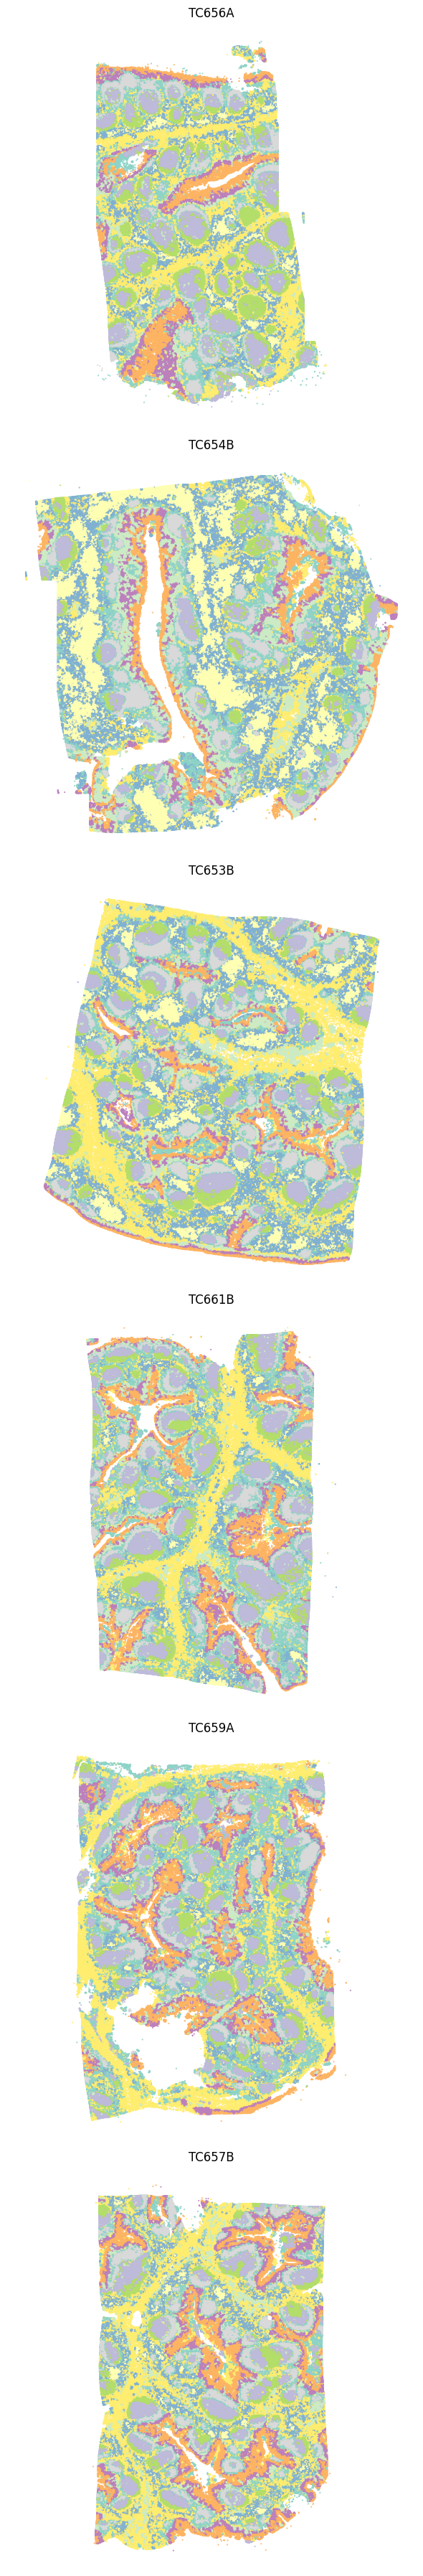

In [3]:
# plot original neighborhoods

k = 40
n_neighborhoods = 10
neighborhood_name = "neighborhood"+"k"+str(k)+"n"+str(n_neighborhoods)

cells[neighborhood_name] = cells[neighborhood_name].astype('category')
samples = cells['sample'].unique()
n = len(samples)
cols = 1
rows = int(np.ceil(n/cols))

fig, axes = plt.subplots(rows, cols, figsize=(cols*6, rows*6), squeeze=False)

for ax, sample in zip(axes.flatten(), samples):
    df = cells[cells['sample'] == sample]
    sc = ax.scatter(
        df['x'], df['y'],
        c=df[f'neighborhoodk{k}n{n_neighborhoods}'].cat.codes,  
        cmap='Set3',
        s=1,
        marker='.'
    )
    ax.set_title(sample)
    ax.set_aspect('equal')
    ax.axis('off')

    
plt.tight_layout()
plt.show()

## Method 1: Merging the GC regions (LZ/DZ and inbetween) by KNN

In [4]:
# -------------------- CONFIG --------------------
k = 40                         
n_neighborhoods = 10
neigh_col = f"neighborhoodk{k}n{n_neighborhoods}"

GC_LABELS = {2, 5}             # LZ=2, DZ=5
MERGED_GC_CODE = 2             # keep "2" as the unified GC code (5 → 2)

###########################################################
KNN_K = 500                     # how many spatial neighbors to examine
THRESH = 0.75                   # fraction of neighbors that must be LZ/DZ to flip to GC

# K (neighbors): Bigger K smooths the vote and reduces speckle/holes. If holes persist, raise K first.

# THRESH (GC fraction): Higher threshold is stricter; it prevents marginal interior non-GC from surviving.
# ------------------------------------------------

def merge_gc_and_fill(cells: pd.DataFrame) -> pd.DataFrame:
    """Return a copy of `cells` with a new column where LZ/DZ are merged,
    and interior non-GC clusters surrounded by GC are flipped to GC."""
    out = cells.copy()

    if pd.api.types.is_categorical_dtype(out[neigh_col]):
        lbl = out[neigh_col].cat.codes.to_numpy()
    else:
        # assume already ints 0..n-1
        lbl = out[neigh_col].to_numpy(dtype=np.int32, copy=False)

    # merged 5 -> 2; others unchanged
    merged_lbl = lbl.copy()
    merged_lbl[np.isin(merged_lbl, list(GC_LABELS))] = MERGED_GC_CODE

    is_gc_orig = np.isin(lbl, list(GC_LABELS))

    # container for flips
    flip_to_gc = np.zeros(len(out), dtype=bool)

    # process per sample 
    for sample in tqdm(out["sample"].unique(), desc="GC fill (per sample)"):
        idx = np.flatnonzero(out["sample"].to_numpy() == sample)
        if len(idx) == 0:
            continue

        xy = out.loc[out.index[idx], ["x", "y"]].to_numpy(np.float32, copy=False)
        # build kNN in 2D (BallTree auto via 'auto')
        nn = NearestNeighbors(n_neighbors=min(KNN_K + 1, len(idx)), algorithm="auto")
        nn.fit(xy)
        ind = nn.kneighbors(xy, return_distance=False)

        # drop self 
        if ind.shape[1] > 1:
            ind = ind[:, 1:]

        # neighbor labels (original, before merging)
        neigh_is_gc = is_gc_orig[idx][ind]          # (Ns, K)
        frac_gc = neigh_is_gc.mean(axis=1)          # (Ns,)

        # only allow flipping for non-GC points
        local_flip = (~is_gc_orig[idx]) & (frac_gc >= THRESH)
        flip_to_gc[idx] = local_flip

    # apply flips in the merged label space
    merged_lbl[flip_to_gc] = MERGED_GC_CODE

    # write the new column (categorical, so plotting gets stable colors)
    new_col = f"{neigh_col}_gcMerged_k{KNN_K}_t{int(THRESH*100)}"
    out[new_col] = pd.Categorical(merged_lbl, categories=range(n_neighborhoods))

    return out, new_col


cells_gc, gc_col = merge_gc_and_fill(cells)

GC fill (per sample): 100%|██████████| 6/6 [08:24<00:00, 84.09s/it]


## Method 2: morphology process (used for downstream analysis)

overall better results than method 1

In [38]:
# ---------------- config ----------------
neigh_col       = "neighborhoodk40n10"
GC_LABELS       = {2, 5}
MANTLE_LABEL    = 6
MERGED_GC_CODE  = 2

CELL_DIAM_PX    = 10.0   # cell diameter in px 
PIX_PER_CELL    = 2.0    # grid pixels per cell diameter
grid_step       = CELL_DIAM_PX / PIX_PER_CELL

CLOSE_RADIUS    = 3.0    
HOLE_AREA       = 500
OBJ_AREA_MIN    = 500
MANTLE_MARGIN   = 5.0    # distance from mantle in pixels
INTERIOR_MARGIN = 2.0    # minimum distance from GC boundary to allow flip
# ---------------------------------------

def gc_mask_cleanup_one_sample(df_s):
    # labels & coords
    lbl = (df_s[neigh_col].cat.codes
           if pd.api.types.is_categorical_dtype(df_s[neigh_col])
           else df_s[neigh_col].astype(np.int32)).to_numpy()
    xy  = df_s[["x","y"]].to_numpy(np.float32, copy=False)
    n   = len(df_s)

    # grid extents
    xmin, ymin = xy.min(axis=0) - grid_step
    xmax, ymax = xy.max(axis=0) + grid_step
    W = int(np.ceil((xmax - xmin) / grid_step))
    H = int(np.ceil((ymax - ymin) / grid_step))

    # seeds → grid (rasterize)
    is_gc = np.isin(lbl, list(GC_LABELS))
    gx = ((xy[:,0] - xmin) / grid_step).astype(int).clip(0, W-1)
    gy = ((xy[:,1] - ymin) / grid_step).astype(int).clip(0, H-1)

    gc_grid = np.zeros((H, W), dtype=bool)
    gc_grid[gy[is_gc], gx[is_gc]] = True

    # morphology processing
    se = disk(int(round(CLOSE_RADIUS)))
    gc_closed = binary_closing(gc_grid, footprint=se)
    gc_closed = remove_small_holes(gc_closed, area_threshold=HOLE_AREA)
    gc_closed = remove_small_objects(gc_closed, min_size=OBJ_AREA_MIN)

    # distance to GC boundary on the grid
    # distance to background (outside) within the GC region ≈ interior thickness
    dist_in = dist_edt(gc_closed)
    
    # sample that distance at point locations
    dist_in_pts = dist_in[gy, gx]  # units: grid pixels

    # mantle protection - we don't want to flip mantle
    is_mantle = (lbl == MANTLE_LABEL)
    if is_mantle.any():
        tree_m = cKDTree(xy[is_mantle])
        dist_m, _ = tree_m.query(xy, k=1, workers=-1)  # px
    else:
        dist_m = np.full(n, np.inf, dtype=np.float32)

    # decide flips
    inside_mask = gc_closed[gy, gx]                   # inside GC region (grid)
    deep_inside = dist_in_pts >= INTERIOR_MARGIN      # not near GC edge (grid)
    merged = lbl.copy()

    flip = (~is_gc) & (~is_mantle) & (dist_m >= MANTLE_MARGIN) & inside_mask & deep_inside
    merged[is_gc] = MERGED_GC_CODE
    merged[flip]  = MERGED_GC_CODE
    return merged

def apply_gc_cleanup(cells):
    out = cells.copy()
    new_col = f"{neigh_col}_gcClosed"
    merged_all = np.empty(len(out), dtype=np.int32)
    for smp in out["sample"].unique():
        idx = out.index[out["sample"] == smp]
        merged_all[idx] = gc_mask_cleanup_one_sample(out.loc[idx])
    out[new_col] = pd.Categorical(merged_all)
    return out, new_col
    
# run
cells_gc, gc_col = apply_gc_cleanup(cells)

In [39]:
print(cells_gc)

                   y            x  sample               cell l1_cluster  \
0        2407.581055  1305.330933  TC656A  TC656A_aaaabpaf-1   Mono/Mac   
1        2405.339355  1315.011719  TC656A  TC656A_aaaacjje-1   Mono/Mac   
2        2408.062012  1311.049683  TC656A  TC656A_aaaafkfe-1    Cytotox   
3        2408.108398  1354.852051  TC656A  TC656A_aaaagiap-1        MBC   
4        2405.250732  1368.959106  TC656A  TC656A_aaaajchh-1   Mono/Mac   
...              ...          ...     ...                ...        ...   
6290471  2072.744629  2676.810303  TC657B  TC657B_oinacpac-1      Mural   
6290472  1410.919434  2350.359375  TC657B  TC657B_oinafllb-1        ASC   
6290473  1332.439331  2397.635742  TC657B  TC657B_oinaibcm-1   Mono/Mac   
6290474  1300.095703  2459.692627  TC657B  TC657B_oinajejl-1    Naive T   
6290475  1749.690796  2516.006348  TC657B  TC657B_oinamhhd-1   Mono/Mac   

        l2_cluster  l1_cluster_id  l2_cluster_id  0  1  ...  18  19  20  21  \
0         Mono/Mac  

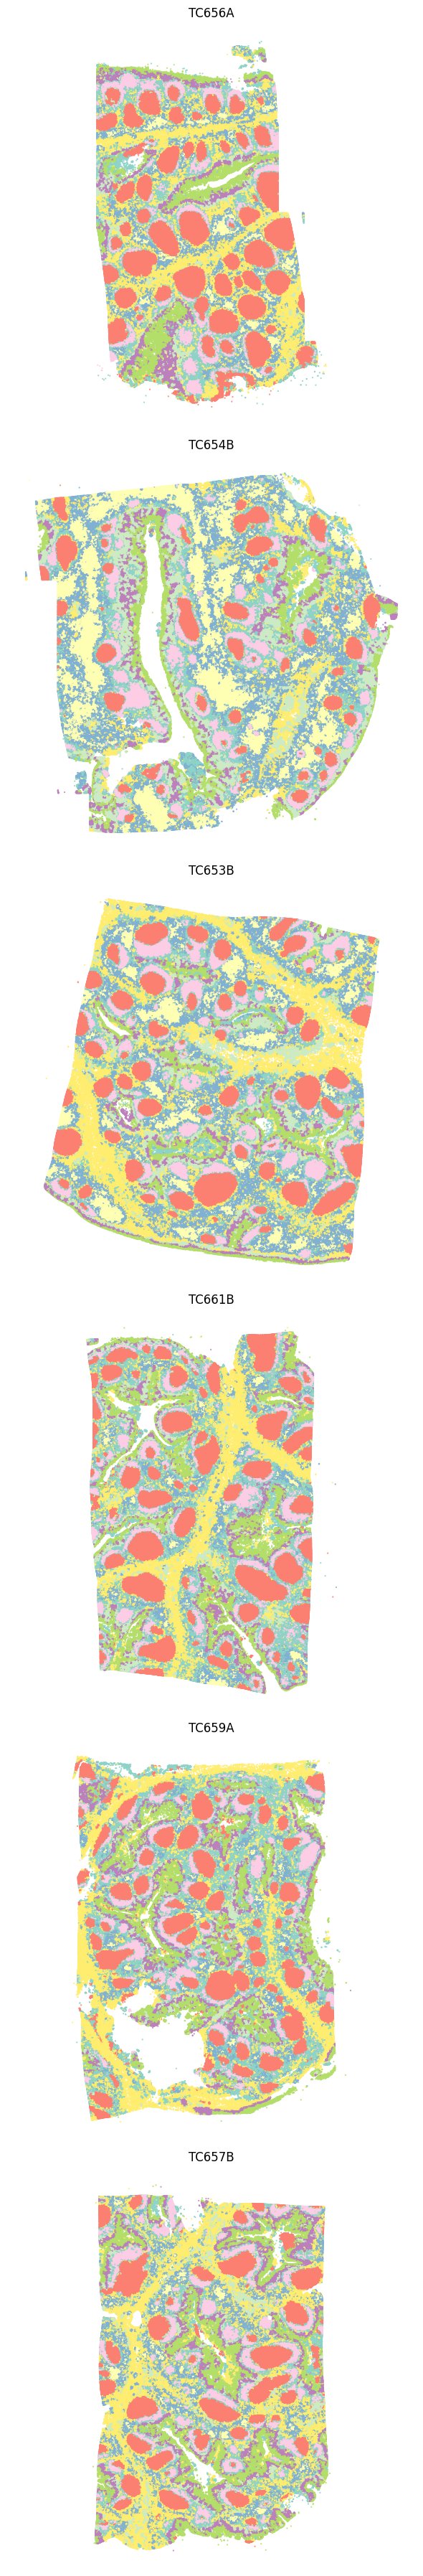

In [40]:
# visualized combined-GC

import matplotlib.pyplot as plt
import numpy as np

samples = cells_gc["sample"].unique()
cols = 1
rows = int(np.ceil(len(samples) / cols))
fig, axes = plt.subplots(rows, cols, figsize=(cols*6, rows*6), squeeze=False)

for ax, sample in zip(axes.flatten(), samples):
    df = cells_gc[cells_gc["sample"] == sample]
    sc = ax.scatter(
        df["x"], df["y"],
        c=df[gc_col].cat.codes,  \
        s=1, marker='.', cmap='Set3'
    )
    ax.set_title(sample)
    ax.set_aspect('equal')
    ax.axis('off')

plt.tight_layout()
plt.show()

## Disgnostic plots and reports

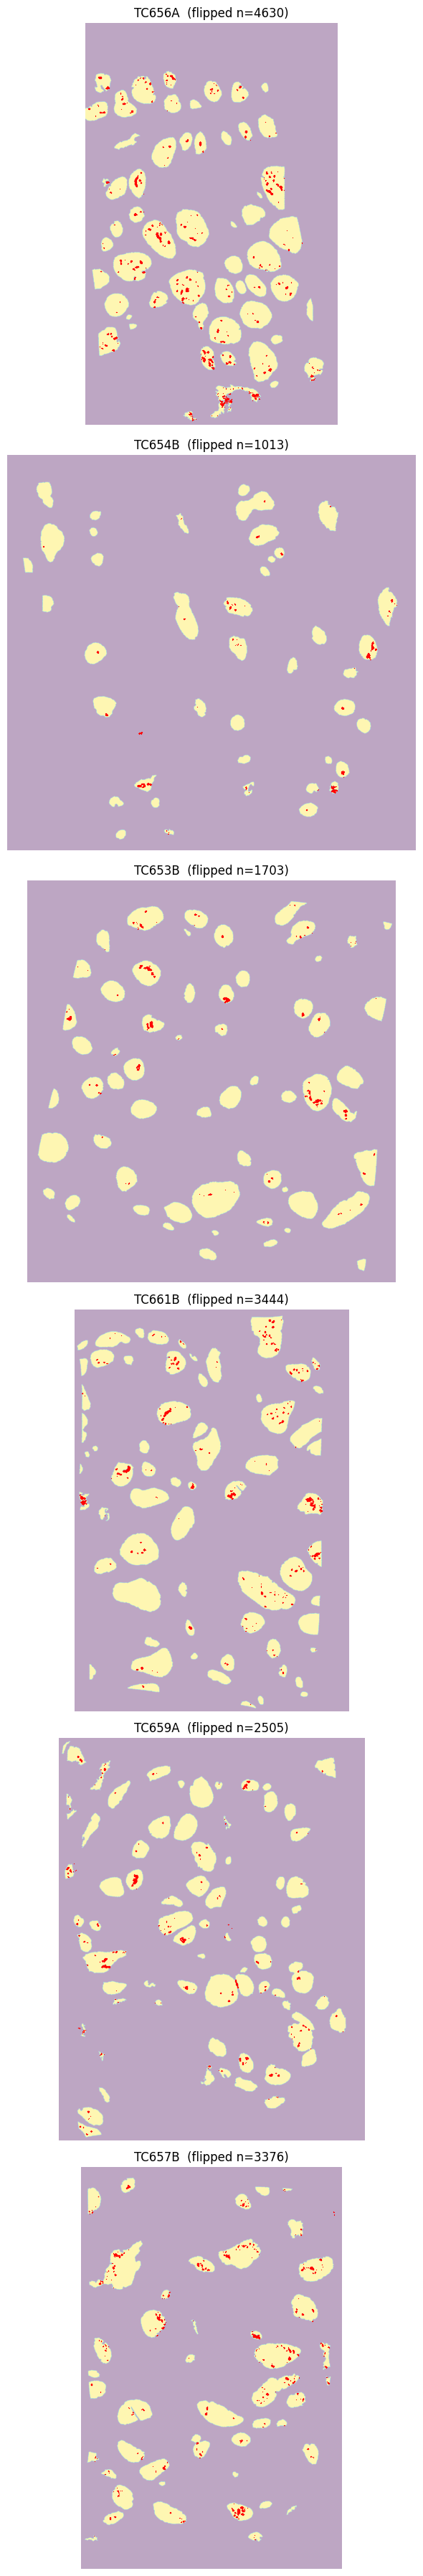

In [41]:
# Diagnosis plot

def _gc_mask_for_sample(df_s):
    """Rebuild the cleaned GC raster (gc_closed) and its extent for plotting."""
    # labels & coords
    lbl = (df_s[neigh_col].cat.codes
           if hasattr(df_s[neigh_col], "cat")
           else df_s[neigh_col].astype(np.int32)).to_numpy()
    xy  = df_s[["x","y"]].to_numpy(np.float32, copy=False)

    # grid extents
    xmin, ymin = xy.min(axis=0) - grid_step
    xmax, ymax = xy.max(axis=0) + grid_step
    W = int(np.ceil((xmax - xmin) / grid_step))
    H = int(np.ceil((ymax - ymin) / grid_step))

    # seed mask on grid
    is_gc = np.isin(lbl, list(GC_LABELS))
    gx = ((xy[:,0] - xmin) / grid_step).astype(int).clip(0, W-1)
    gy = ((xy[:,1] - ymin) / grid_step).astype(int).clip(0, H-1)
    gc_grid = np.zeros((H, W), dtype=bool)
    gc_grid[gy[is_gc], gx[is_gc]] = True

    # morphology → cleaned GC region
    se = disk(int(round(CLOSE_RADIUS)))
    gc_closed = binary_closing(gc_grid, footprint=se)
    gc_closed = remove_small_holes(gc_closed, area_threshold=HOLE_AREA)
    gc_closed = remove_small_objects(gc_closed, min_size=OBJ_AREA_MIN)

    # extent tells imshow how to place the raster in x/y units (pixels here)
    extent = [xmin, xmax, ymin, ymax]  # [x0, x1, y0, y1]
    return gc_closed, extent

# build mask of flipped points
orig_gc = cells_gc[neigh_col].isin([2, 5])
final_gc = (cells_gc[gc_col].astype(int) == MERGED_GC_CODE)
flipped_mask = (~orig_gc) & final_gc

# plot per sample
samples = cells_gc["sample"].unique()
cols = 1
rows = int(np.ceil(len(samples) / cols))
fig, axes = plt.subplots(rows, cols, figsize=(cols*6, rows*6), squeeze=False)

for ax, sample in zip(axes.flatten(), samples):
    df_s = cells_gc[cells_gc["sample"] == sample]
    # 1) background = GC region (cleaned)
    gc_closed, extent = _gc_mask_for_sample(df_s)
    ax.imshow(gc_closed.astype(float),
              extent=extent,
              origin="lower",   # so y axis matches your scatter orientation
              alpha=0.35)       # semi-transparent so dots are visible

    # 2) overlay flipped points (only those in this sample)
    df_flip = cells_gc[(cells_gc["sample"] == sample) & flipped_mask]
    ax.scatter(df_flip["x"], df_flip["y"], c="red", s=3, marker=".", linewidths=0)

    ax.set_title(f"{sample}  (flipped n={len(df_flip)})")
    ax.set_aspect("equal")
    ax.axis("off")

plt.tight_layout()
plt.show()

In [42]:
# stats report

# Identify flipped cells
orig_gc = cells_gc["neighborhoodk40n10"].isin([2, 5])
final_gc = (cells_gc[gc_col].astype(int) == 2)
flipped_mask = (~orig_gc) & final_gc

flipped_df = cells_gc[flipped_mask].copy()

# Stats by original neighborhood ID
counts_neigh = flipped_df["neighborhoodk40n10"].value_counts().sort_index()
print("Flipped cells by original neighborhood ID:")
print(counts_neigh)

# percentage relative to all flipped
counts_l2_pct = counts_l2 / counts_l2.sum() * 100
print("\nFlipped cells by l2_cluster (percentages):")
print(counts_l2_pct.round(2))

Flipped cells by original neighborhood ID:
0      957
1        0
2        0
3      114
4        0
5        0
6        0
7        0
8    13852
9     1748
Name: neighborhoodk40n10, dtype: int64

Flipped cells by l2_cluster (percentages):
ASC           41.53
LZ GCB        11.77
Mono/Mac       8.05
DZ GCB         7.72
FDC            7.06
Naive B        3.70
Cytotox        2.99
Art Endo       2.58
Mural          2.43
Tfh GNG4       1.79
Naive T        1.53
Tfh CXCL13     1.44
Tfh DZ         1.37
Cycling        1.29
Tfh BLIMP1     1.05
Tfh Myl        0.89
Tfh S1PR2      0.73
FRC            0.53
Tfh Stim       0.38
DC             0.21
Gran           0.19
Tconv Myl      0.19
MBC            0.12
Tfh CCR6       0.09
Treg           0.07
Tcm            0.06
Tfh NFATC1     0.06
Tconv          0.03
Tfh Prolif     0.03
LEC            0.03
Tfh Circ       0.03
PDC            0.02
Trab Fib       0.02
Int Epi        0.01
Mast           0.01
Name: l2_cluster, dtype: float64
